# Mixture of K Gaussian Process Experts Example

This notebook is a basic example of configuring and training a mixture of K GP experts (using MixtureOfSVGPExperts) on the motorcycle dataset. In this example we use three experts.

In [1]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt

from gpflow import default_float
from gpflow.utilities import print_summary

from mogpe.models.experts import SVGPExperts, SVGPExpert
from mogpe.models.gating_network import SVGPGatingFunction, SVGPGatingNetworkMulti
from mogpe.models.mixture_model import MixtureOfSVGPExperts

from mogpe.data.utils import load_mcycle_dataset
from mogpe.training.utils import training_tf_loop
from mogpe.visualization.plotter import Plotter1D

Let's start by configuring some of the model and training parameters.

In [20]:
num_inducing = 10
batch_size = 30
num_inducing_samples = 1
logging_epoch_freq = 100
num_epochs = 15000

Load the motorcycle dataset and plot it to see what we're dealing with.

Input data shape:  (133, 1)
Output data shape:  (133, 1)


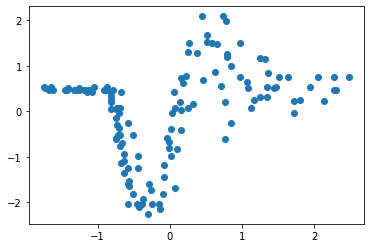

In [21]:
data_file = '../../data/external/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data = X.shape[0]
input_dim = X.shape[1]
output_dim = Y.shape[1]
plt.scatter(X, Y)

In order to initialie the MixtureOfSVGPExperts class for more than two experts we must pass it an instance of SVGPExperts and an instance of SVGPGatingNetworkMulti. Let's start by creating an instance of SVGPExperts. To do this we must first create three SVGPExpert instances and pass them as a list to SVGPExperts. Let's create out first expert. 

In [22]:
noise_var_1 = 0.9
kern_var_1 = 2.
lengthscale_1 = 0.5

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_1)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_1 = tf.convert_to_tensor([lengthscale_1] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_1))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_1 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)

Let's create a second expert with the same initial parameters.

In [23]:
noise_var_2 = 0.9
kern_var_2 = 2.0
lengthscale_2 = 0.5

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_2)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale_2 = tf.convert_to_tensor([lengthscale_2] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_2))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_2 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)


Let's now create our third expert with a longer lengthscale and lower noise.

In [24]:
noise_var_3 = 0.0011
kern_var_3 = 0.1
lengthscale_3 = 10.

idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

mean_function = gpf.mean_functions.Constant()

likelihood = gpf.likelihoods.Gaussian(noise_var_3)

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list 
    lengthscale_3 = tf.convert_to_tensor([lengthscale_3] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale_3))
kernel = gpf.kernels.SeparateIndependent(kern_list)

expert_3 = SVGPExpert(kernel, likelihood, mean_function=mean_function, inducing_variable=inducing_variable)

We can now create an instance of SVGPExperts by passing our two experts as a list.

In [25]:
experts_list = [expert_1, expert_2, expert_3]
experts = SVGPExperts(experts_list)
print_summary(experts)

╒═══════════════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════════╕
│ name                                                              │ class     │ transform        │ prior   │ trainable   │ shape       │ dtype   │ value                 │
╞═══════════════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════════╡
│ SVGPExperts.experts_list[0].mean_function.c                       │ Parameter │                  │         │ True        │ (1,)        │ float64 │ [0.]                  │
├───────────────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────────┤
│ SVGPExperts.experts_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus         │         │ True        │ ()        

We now need to create an instance of SVGPGatingNetworkMulti which requires a list of at least two SVGPGatingFunction instances for its construction. Let's go ahead and create our gating functions.

In [26]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

noise_var = 0.1
lengthscale = 1.
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 2
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function_1 = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)

In [27]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

noise_var = 0.1
lengthscale = 1.
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 2
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function_2 = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)

In [28]:
idx = np.random.choice(range(num_data), size=num_inducing, replace=False) 
inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)

inducing_variable = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_variable))

noise_var = 0.1
lengthscale = 1.
mean_function = gpf.mean_functions.Zero()

q_mu = np.zeros((num_inducing, output_dim)) + np.random.randn(num_inducing, output_dim) * 2
q_sqrt = np.array([
    10 * np.eye(num_inducing, dtype=default_float())
    for _ in range(output_dim)
])

kern_list = []
for _ in range(output_dim):
    # Create multioutput kernel from kernel list
    lengthscale = tf.convert_to_tensor([lengthscale] * input_dim,
                                        dtype=default_float())
    kern_list.append(gpf.kernels.RBF(lengthscales=lengthscale))
kernel = gpf.kernels.SeparateIndependent(kern_list)

gating_function_3 = SVGPGatingFunction(kernel,
                                     inducing_variable,
                                     mean_function,
                                     q_mu=q_mu,
                                     q_sqrt=q_sqrt)

We can now use our three gating functions to instantiate our gating network (SVGPGatingNetworkMulti).

In [29]:
gating_functions = [gating_function_1, gating_function_2, gating_function_3]
gating_network = SVGPGatingNetworkMulti(gating_functions)
print_summary(gating_network)

╒══════════════════════════════════════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤═══════════════════╕
│ name                                                                                 │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value             │
╞══════════════════════════════════════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪═══════════════════╡
│ SVGPGatingNetworkMulti.gating_function_list[0].kernel.kernels[0].variance            │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0               │
├──────────────────────────────────────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼───────────────────┤
│ SVGPGatingNetworkMulti.gating_function_list[0].kernel.kernels[0].len

We now have all the components to construct our MixtureOfSVGPExperts model so let's go ahead and do it. The num_inducing_samples variable defines how many samples should be drawn from the inducing point distributions during training.

In [30]:
model = MixtureOfSVGPExperts(gating_network=gating_network, experts=experts, num_inducing_samples=num_inducing_samples, num_data=num_data)

We can use the Plotter1D class from visualization to plot our model before training.

Plotting gating network...
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)
Plotting experts y...
axs
(3,)
Plotting y...
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)


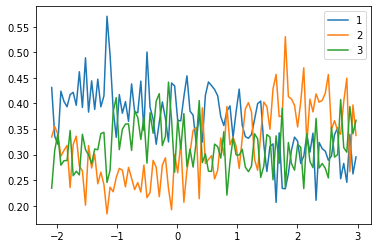

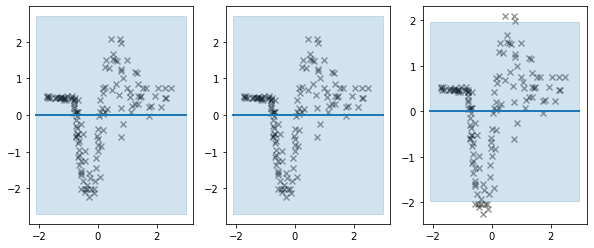

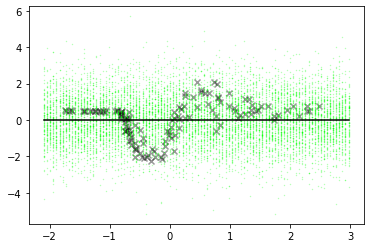

In [31]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

We must now convert our numpy data set into a TensorFlow data set and set it up for stochastic optimisation by setting the batch size. We set drop_remainder=True to ensure the model receives the batch size.

In [32]:
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_data // 2
num_batches_per_epoch = num_data // batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(
    buffer_size=shuffle_buffer_size).batch(batch_size, drop_remainder=True))

We then use GPflows training_loss_closure method to get our training loss.

In [33]:
training_loss = model.training_loss_closure(iter(train_dataset))

In mogpe.training.utils four training loops are defined. Here we use the simple training_tf_loop which runs the Adam optimizer on model with training_loss as the objective function. The loop does not use any TensorBoard monitoring.

In [34]:
training_tf_loop(model,
                 training_loss,
                 epochs=num_epochs,
                 num_batches_per_epoch=num_batches_per_epoch,
                 logging_epoch_freq=logging_epoch_freq)

(1, 1, 30, 3)
(1, 1, 30, 3)
inside single output dim
(1, 30, 3)
inside single inducing sample
(30, 3)
hi aidan
inside epsilon
Tensor("ELBO/predict_mixing_probs/loop_body/loop_body/random_normal:0", shape=(100, 30, 3), dtype=float64)
(1, 1, 30, 3)
(1, 30, 1, 3)
(1, 1, 30, 3)
(1, 1, 30, 3)
inside single output dim
(1, 30, 3)
inside single inducing sample
(30, 3)
hi aidan
inside epsilon
Tensor("ELBO/predict_mixing_probs/loop_body_1/loop_body/random_normal:0", shape=(100, 30, 3), dtype=float64)
(1, 1, 30, 3)
(1, 30, 1, 3)
mixing_probs
(1, 30, 1, 3)
batched dists
tfp.distributions.Normal("ELBO_predict_experts_prob_Normal", batch_shape=[1, 30, 1, 3], event_shape=[], dtype=float64)
y
Tensor("ELBO/predict_experts_prob/ExpandDims_1:0", shape=(1, 30, 1, 1), dtype=float64)
expected experts
(1, 30, 1, 3)
marginalised indicator variable
(1, 30, 1, 1)
averaged samples
(30, 1, 1)
Ignore covariance in output dimension
(30, 1)
Reduce sum over num_data
(1,)
Reduce sum over output_dim to get loss
()
Epoc

Let's visualise what we have learned.

Plotting gating network...
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)
Plotting experts y...
axs
(3,)
Plotting y...
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)
(1, 100, 3)
(1, 100, 3)
inside single output dim
(100, 3)
(1, 100, 3)
(100, 1, 3)


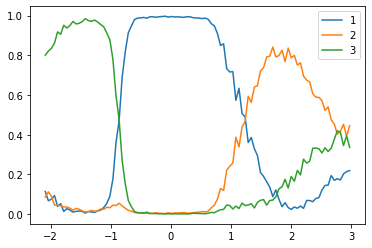

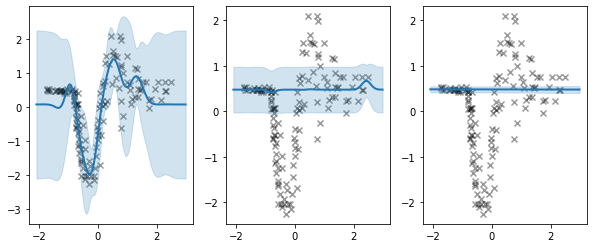

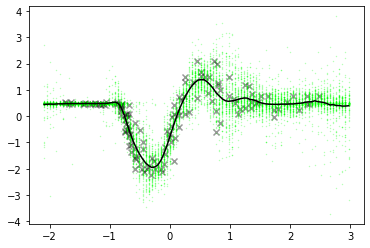

In [35]:
plotter.plot_model()